In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Objective

# Data Collection

The data here has already been collected in this case, as repeating the same collection process takes several days.

In [2]:
# An array of dataframes, one for each 'fandom'
fandom_dfs = []

csv_filenames = ['mha.csv', 'haikyuu.csv', 'aot.csv', 'bsd.csv', 'danganronpa.csv', 'hetalia.csv', 'jojo.csv', 'naruto.csv', 'onepiece.csv', 'pokemon.csv']

for csv in csv_filenames:
    fandom_dfs.append(pd.read_csv('data/' + csv))

for i in range(len(fandom_dfs)):
    fandom_dfs[i] = fandom_dfs[i][['Title', 'Author', 'Kudos', 'Comments', 'Bookmarks', 'Hits', 'Tags']]

# An array of relevant tags according to AO3's open data from 2021
tag_df = pd.read_csv('data/ordered_tags_20210226.csv')

# Data Cleaning

In [3]:
# returns (true, canon name) if in database, and (false, none) else
def inDatabase(name):
    current = name
    while True:
        index = tag_df["name"].searchsorted(current)
        if current != tag_df["name"].iloc[index]:
            return (False, None)
        
        if tag_df['canonical'].iloc[index]:
            return (True, tag_df['name'].iloc[index])
        
        if pd.isna(tag_df['merger_id'].iloc[index]):
            return (False, None)
        
        current = tag_df['name'].iloc[int(tag_df['merger_id'].iloc[index])]
        
# Generates a list of tags that have canonical names
def find_canonical_tags(tags):
    tags = tags[2:-2].split('], [')
    found_tags = []
    if tags[0] == '':
        return found_tags
    for tag in tags:
        pair = tag.split(', ')
        name = pair[0][1:-1]
        link = pair[1][1:-1]
        in_database, canonical = inDatabase(name)
        if in_database:
            found_tags.append(canonical)
            
    return found_tags

# Generates a listof tags that do not have a canonical name
def find_missing_tags(tags):
    unfound_tags = []
    if tags[0] == '':
        return unfound_tags
    for tag in tags:
        pair = tag.split(', ')
        name = pair[0][1:-1]
        link = pair[1][1:-1]
        in_database, canonical = inDatabase(name)
        if not in_database:
            unfound_tags.append((False, name, link))
            
    return unfound_tags

## Tags without a Common Name

Most tags have a common name that they all route to. This is AO3's way of keeping their tagging system organized and compact. Tags that don't really add to the description of the work don't have this routing, although sometimes relevant tags are unmarked, since this is done by hand. 

As the list of common names, called "canonical names", is pulled from a 2021 dataset of tags provided by AO3 themselves, this section aimed to determine whether it was worth seeing if any of the tags have since been updated.

After manually examining the list of the most frequent tags within this category, it was ultimately decided that it would be best to ignore tags not included in the 2021 dataset.

In [4]:
# missing_tags_all = []
# for fandom_df in fandom_dfs:
#     missing_tags = {}
#     for i in range(fandom_df.shape[0]):
#         unfound = find_missing_tags(fandom_df.iloc[i]['Tags'][2:-2].split('], ['))
#         for _, name, link in unfound:
#             if name in missing_tags:
#                 missing_tags[name][1] += 1
#             else:
#                 missing_tags[name] = [link, 1]
                
#     missing_tags_all.append(missing_tags)

# for group in missing_tags_all:
#     print(len(group))

In [5]:
# missing_tags_counter = {}
# for i in range(len(missing_tags_all)):
#     for name, data in missing_tags_all[i].items():
#         if name not in missing_tags_counter:
#             missing_tags_counter[name] = [0 for i in range(len(missing_tags_all))]
#         missing_tags_counter[name][i] = 1

# min_thresh = 10
# for i in range(2, 11):
#     repeated_tags = 0
#     for tag, counters in missing_tags_counter.items():
#         if sum(counters) >= i:
#             repeated_tags += 1
        
#     print(f'{i}: {repeated_tags}')

## Tags with Common Names

In [6]:
for fandom_df in fandom_dfs:
    fandom_df['Tags'] = fandom_df['Tags'].apply(find_canonical_tags)

In [7]:
tags_per_fandom = []
for fandom_df in fandom_dfs:
    tags = set()
    for i in range(fandom_df.shape[0]):
        tags.update(fandom_df.iloc[i]['Tags'])
    
    tags_per_fandom.append(tags)
    print(len(tags))

10826
8811
7450
5384
5842
5861
5850
6741
5088
5429


In [8]:
tag_spread_counter = {}
for i in range(len(tags_per_fandom)):
    for tag in tags_per_fandom[i]:
        if tag not in tag_spread_counter:
            tag_spread_counter[tag] = [0 for i in range(len(tags_per_fandom[i]))]
            
        tag_spread_counter[tag][i] = 1

In [9]:
tag_frequencies = []
tag_frequencies_min = []
for i in range(1, 11):
    repeated_tags = 0
    repeated_tags_min = 0
    for tag, counters in tag_spread_counter.items():
        if sum(counters) == i:
            repeated_tags += 1
        if sum(counters) >= i:
            repeated_tags_min += 1
            
    tag_frequencies.append(repeated_tags)
    tag_frequencies_min.append(repeated_tags_min)
    
print(tag_frequencies)
print(tag_frequencies_min)

[14627, 1239, 781, 640, 568, 508, 530, 570, 684, 2496]
[22643, 8016, 6777, 5996, 5356, 4788, 4280, 3750, 3180, 2496]


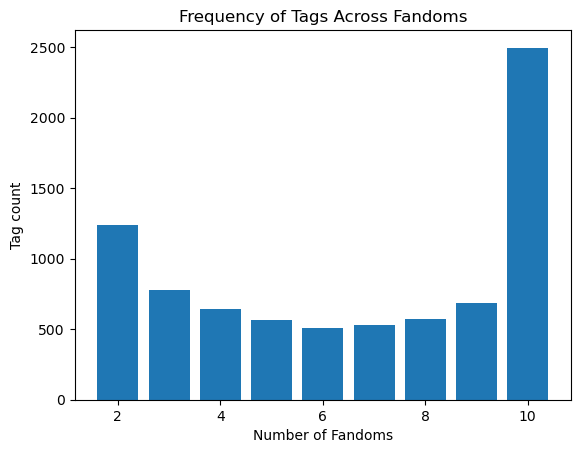

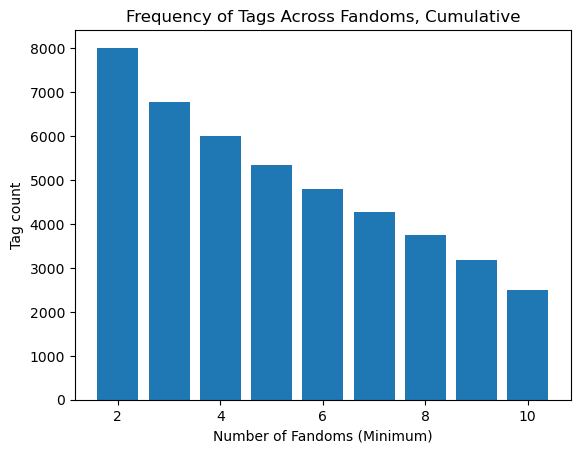

In [10]:
plt.bar(range(2, 11), tag_frequencies[1:])
plt.title('Frequency of Tags Across Fandoms')
plt.xlabel('Number of Fandoms')
plt.ylabel('Tag count')
plt.show()

plt.bar(range(2, 11), tag_frequencies_min[1:])
plt.title('Frequency of Tags Across Fandoms, Cumulative')
plt.xlabel('Number of Fandoms (Minimum)')
plt.ylabel('Tag count')
plt.show()

## Refactor Metrics

The extraction algorithm used the number -1 to represent a value that was missing. However, it appears that the website hides metrics that are valued at zero, meaning that every occurence of -1 is actually supposed to be a 0.

In [11]:
for fandom_df in fandom_dfs:
    print(len(fandom_df))
    display(fandom_df[fandom_df == -1].sum(axis = 0))
    

99980


Title             0
Author            0
Kudos           0.0
Comments    -3154.0
Bookmarks    -193.0
Hits            0.0
Tags              0
dtype: object

100000


Title              0
Author             0
Kudos            0.0
Comments    -18473.0
Bookmarks   -12452.0
Hits             0.0
Tags               0
dtype: object

42334


Title              0
Author             0
Kudos         -549.0
Comments    -11539.0
Bookmarks    -9191.0
Hits             0.0
Tags               0
dtype: object

34819


Title             0
Author            0
Kudos        -295.0
Comments    -9052.0
Bookmarks   -6352.0
Hits            0.0
Tags              0
dtype: object

35925


Title             0
Author            0
Kudos        -429.0
Comments    -8165.0
Bookmarks   -7322.0
Hits            0.0
Tags              0
dtype: object

33378


Title              0
Author             0
Kudos         -937.0
Comments    -14353.0
Bookmarks   -12268.0
Hits             0.0
Tags               0
dtype: object

30086


Title             0
Author            0
Kudos        -413.0
Comments    -9063.0
Bookmarks   -7107.0
Hits            0.0
Tags              0
dtype: object

59399


Title              0
Author             0
Kudos        -1020.0
Comments    -15228.0
Bookmarks   -11816.0
Hits             0.0
Tags               0
dtype: object

29886


Title             0
Author            0
Kudos        -289.0
Comments    -7576.0
Bookmarks   -5411.0
Hits            0.0
Tags              0
dtype: object

30745


Title              0
Author             0
Kudos        -1420.0
Comments    -10438.0
Bookmarks    -9458.0
Hits             0.0
Tags               0
dtype: object

In [28]:
filtered_dfs = []
for fandom_df in fandom_dfs:
    filtered_df = fandom_df.copy()
    filtered_df.loc[fandom_df['Kudos'] == -1,'Kudos'] = 0
    filtered_df.loc[fandom_df['Comments'] == -1,'Comments'] = 0
    filtered_df.loc[fandom_df['Bookmarks'] == -1,'Bookmarks'] = 0
    filtered_df.loc[fandom_df['Hits'] == -1,'Hits'] = 0
    filtered_dfs.append(filtered_df)

In [136]:
for filtered_df in filtered_dfs:
    print(len(filtered_df))

99980
100000
42334
34819
35925
33378
30086
59399
29886
30745


## Tag Filtering

Tag filtering is composed of the following parts:
1. Calculate number of occurences for each tag
2. Calculate spread of each tag over all fandoms
3. Remove tags that do not meet thresholds
4. Remove data without any tags

Additionally, data regarding tag metrics will be collected, but not used in the filtering process.

In [46]:
min_occurences = 100
min_fandom_occurences = 2

In [105]:
# Each stat is an array of 11 numbers
# 0-9 for each fandom, 10 represents the total
# Stats: [name, count, kudos, comments, bookmarks, hits]
tag_stats_dict = {}
count_ind = 1
kudo_ind = 12
comment_ind = 23
bookmark_ind = 34
hit_ind = 45

for i in range(len(filtered_dfs)):
    df = filtered_dfs[i]
    for j in range(df.shape[0]):
        work = df.iloc[j]
        for tag in work.Tags:
            if tag not in tag_stats_dict:
                tag_stats_dict[tag] = [0] 
                for _ in range(5):
                    tag_stats_dict[tag].append([0 for x in range(len(filtered_dfs))])
                    tag_stats_dict[tag].append(0)
                tag_stats_dict[tag][0] = tag

            tag_stats_dict[tag][1][i] += 1
            tag_stats_dict[tag][2] += 1
            tag_stats_dict[tag][3][i] += work.Kudos
            tag_stats_dict[tag][4] += work.Kudos
            tag_stats_dict[tag][5][i] += work.Comments
            tag_stats_dict[tag][6] += work.Comments
            tag_stats_dict[tag][7][i] += work.Bookmarks
            tag_stats_dict[tag][8] += work.Bookmarks
            tag_stats_dict[tag][9][i] += work.Hits
            tag_stats_dict[tag][10] += work.Hits

            
    
#     tags_per_fandom.append(tags)
#     print(len(tags))

In [180]:
tag_stats = list(tag_stats_dict.values())
filtered_tags_df = pd.DataFrame(tag_stats, columns = ['Name', 'Count', 'Total Count', 'Kudos', 'Total Kudos', 'Comments', 'Total Comments', 'Bookmarks', 'Total Bookmarks', 'Hits', 'Total Hits'])

In [181]:
def fandom_appearances(counts):
    total_counts = 0
    for count in counts:
        total_counts += count
        
    threshold = total_counts * 0.1
    total = 0
    for count in counts:
        if count > threshold:
            total += 1
    return total        
    
filtered_tags_df['Spread'] = filtered_tags_df['Count'].apply(fandom_appearances)
filtered_tags_df

,Name,Count,Total Count,Kudos,Total Kudos,Comments,Total Comments,Bookmarks,Total Bookmarks,Hits,Total Hits,Spread
0,Alternate Universe - Canon Divergence,"[6648, 2456, 1711, 1654, 1868, 92, 1443, 6009,...",25108,"[5559155, 463251, 219324, 310376, 255720, 3586...",10089060,"[914535, 52440, 29493, 28309, 56320, 643, 3023...",1533514,"[1112736, 68015, 36562, 42074, 27675, 329, 224...",1955635,"[93309455, 5188600, 3563130, 3683255, 4581961,...",159410364,2
1,BAMF Midoriya Izuku,"[4429, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4429,"[5594336, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5594336,"[869101, 0, 0, 0, 0, 0, 0, 0, 0, 0]",869101,"[1154737, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1154737,"[103917237, 0, 0, 0, 0, 0, 0, 0, 0, 0]",103917237,1
2,Parental Yagi Toshinori | All Might,"[3477, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3477,"[3814634, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3814634,"[619174, 0, 0, 0, 0, 0, 0, 0, 0, 0]",619174,"[801986, 0, 0, 0, 0, 0, 0, 0, 0, 0]",801986,"[66716756, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66716756,1
3,Alternate Universe - The Sixth Sense Fusion,"[14, 1, 0, 0, 0, 0, 0, 0, 0, 0]",15,"[108103, 45, 0, 0, 0, 0, 0, 0, 0, 0]",108148,"[23376, 9, 0, 0, 0, 0, 0, 0, 0, 0]",23385,"[23638, 8, 0, 0, 0, 0, 0, 0, 0, 0]",23646,"[3021844, 437, 0, 0, 0, 0, 0, 0, 0, 0]",3022281,1
4,Bakugou Katsuki Swears A Lot,"[11029, 0, 0, 1, 0, 0, 0, 0, 0, 0]",11030,"[7354536, 0, 0, 253, 0, 0, 0, 0, 0, 0]",7354789,"[856446, 0, 0, 22, 0, 0, 0, 0, 0, 0]",856468,"[1221263, 0, 0, 33, 0, 0, 0, 0, 0, 0]",1221296,"[103132464, 0, 0, 2296, 0, 0, 0, 0, 0, 0]",103134760,1
...,...,...,...,...,...,...,...,...,...,...,...,...
22638,Nanashima | Sevii Islands (Pokemon),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 3]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 82]",82,1
22639,Supportive Victor Nikiforov,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 213]",213,1
22640,Team Sweden,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 8]",8,1
22641,Pokemon Pearl Version,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37]",37,1


In [182]:
filtered_tags_df = filtered_tags_df[filtered_tags_df['Spread'] > 1]
print(len(filtered_tags_df))
filtered_tags_df = filtered_tags_df[filtered_tags_df['Total Count'] > 100]
print(len(filtered_tags_df))
view = filtered_tags_df[filtered_tags_df['Spread'] == 2]
display(view)
display(len(view))

7683
1905


,Name,Count,Total Count,Kudos,Total Kudos,Comments,Total Comments,Bookmarks,Total Bookmarks,Hits,Total Hits,Spread
0,Alternate Universe - Canon Divergence,"[6648, 2456, 1711, 1654, 1868, 92, 1443, 6009,...",25108,"[5559155, 463251, 219324, 310376, 255720, 3586...",10089060,"[914535, 52440, 29493, 28309, 56320, 643, 3023...",1533514,"[1112736, 68015, 36562, 42074, 27675, 329, 224...",1955635,"[93309455, 5188600, 3563130, 3683255, 4581961,...",159410364,2
6,Queerplatonic Relationships,"[244, 145, 20, 31, 22, 11, 17, 44, 31, 26]",591,"[297073, 40537, 4878, 4151, 1619, 720, 1268, 9...",367018,"[60525, 4841, 412, 244, 296, 147, 427, 1277, 5...",69042,"[60704, 8248, 629, 358, 173, 93, 147, 2353, 97...",73788,"[6712677, 579104, 45992, 50222, 25002, 14471, ...",7685592,2
9,Panic Attacks,"[2444, 949, 207, 362, 471, 80, 183, 229, 198, ...",5431,"[1984564, 242119, 27577, 103773, 72296, 4718, ...",2695071,"[258095, 28228, 3934, 9239, 9883, 1511, 3373, ...",363322,"[353364, 31094, 3792, 12676, 6540, 528, 3552, ...",457443,"[31828241, 3477553, 492070, 1418068, 1030152, ...",43112972,2
16,Misunderstandings,"[1444, 1047, 158, 188, 147, 131, 134, 329, 171...",3845,"[1062036, 339306, 32735, 55483, 24457, 12203, ...",1753517,"[93011, 24580, 4368, 3835, 3330, 1298, 3782, 1...",157452,"[175775, 47666, 4708, 6854, 2246, 1268, 2755, ...",277054,"[11795810, 3463378, 445489, 572128, 320399, 17...",19787538,2
17,Bullying,"[2115, 581, 182, 48, 304, 100, 87, 146, 42, 136]",3741,"[2238703, 183547, 25688, 9743, 41108, 6347, 10...",2563151,"[222099, 17878, 3634, 1314, 7662, 978, 2342, 4...",264153,"[406996, 24468, 3081, 955, 3508, 484, 959, 622...",448688,"[29573293, 2373268, 461169, 150665, 655532, 10...",34247745,2
...,...,...,...,...,...,...,...,...,...,...,...,...
11283,Pre-Time Skip,"[0, 372, 15, 1, 0, 0, 1, 38, 386, 0]",813,"[0, 49759, 670, 180, 0, 0, 84, 10521, 88431, 0]",149645,"[0, 4327, 54, 4, 0, 0, 3, 1128, 5723, 0]",11239,"[0, 6729, 72, 24, 0, 0, 7, 2213, 11548, 0]",20593,"[0, 479605, 7311, 2359, 0, 0, 1321, 169803, 83...",1494415,2
12054,Post-Game(s),"[0, 8, 0, 0, 565, 1, 0, 0, 0, 346]",920,"[0, 993, 0, 0, 76103, 2, 0, 0, 0, 36878]",113976,"[0, 38, 0, 0, 9049, 0, 0, 0, 0, 5764]",14851,"[0, 85, 0, 0, 7725, 0, 0, 0, 0, 4360]",12170,"[0, 7721, 0, 0, 967347, 43, 0, 0, 0, 538607]",1513718,2
13000,19th Century,"[0, 4, 11, 3, 5, 69, 9, 3, 0, 2]",106,"[0, 198, 1324, 172, 194, 2802, 562, 134, 0, 14]",5400,"[0, 23, 325, 8, 19, 394, 81, 32, 0, 8]",890,"[0, 18, 189, 14, 16, 321, 49, 29, 0, 1]",637,"[0, 1633, 26213, 2257, 2457, 47500, 10213, 163...",92106,2
13995,Discord: Poulécriture,"[0, 3, 13, 0, 0, 14, 0, 97, 96, 3]",226,"[0, 44, 79, 0, 0, 86, 0, 434, 769, 65]",1477,"[0, 14, 8, 0, 0, 31, 0, 183, 112, 13]",361,"[0, 2, 10, 0, 0, 8, 0, 8, 19, 2]",49,"[0, 544, 1350, 0, 0, 909, 0, 7507, 10760, 680]",21750,2


426

In [141]:
sum = 0
for filtered_df in filtered_dfs:
    sum += len(filtered_df[filtered_df['Tags'].apply(lambda x: len(x)) != 0])
    
print(sum)

438801
